In [1]:
# Implement GLYMMR alogrithm using some of the pre-existing CCARL framework.

In [1]:
from ccarl.glycan_graph_methods import generate_digraph_from_glycan_string
from ccarl.frequent_subtrees import get_frequent_subtrees
from ccarl.glycan_features import generate_features_from_subtrees
from ccarl.glycan_plotting import draw_glycan_diagram


import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

GLYMMR Algorithm (from Cholleti et al, 2012)
1. Initialize each unique node among all the binding glycans as a subtree of size 1.
   Let this set be S.
2. For each subtree in S:
 - Calculate the number of binding glycans containing the subtree.
 - If the subtree occurs in more than Tb (threshold parameter) binding glycans then:
    - add it to a set of expandable subtrees (ES), and also to a set of possible motifs (PM).
3. If the set ES is not empty:
 - Create an empty set NewS.
 - For each substree in ES
    - Expand the subtree by adding a node such that the new subtree exists in at least one of the binding glycans and add these subtrees to a set NewS.
 - S = NewS
 - Go to step 2
4. For each subtree in the set of possible motifs PM:
 - Count the number of binding glycans (ns) and non-binding glycans (nw) containing the subtree.
 - If ns > Tb and nw < Tn, where Tb and Tn are threshold parameters, add the subtree to a set of motifs, M. Monosaccharides are eliminated from this set.
5. Sort the set of motifs, M, in descending order of the number of binding glycans (ns) containing M and in ascending order of the number of non-binding glycans (nw) containing M.
6. From the sorted set M, add the motifs that do not exist in any non-binders to the output list, L; and add the top m motifs that exist in binders and non-binders to L. 
   The value “m” is a numeric parameter that can be set by user. If the filtering parameter is set to True, then remove motif sub-structures from L that exist in the same number
   of referenced binding glycans compared to a larger motif.

Notes on GLYMMR Algorithm:
    
1. Steps 1-3 appear to be equivalent to frequent subtree mining from binding glycans. The Tb parameter is equivalent to the minimum support threshold.

2. Step 4 enforces that subtrees are mostly absent in negative binding glycans through a threshold parameter `Tn`. Monosaccharides are removed at this stage.

3. Default settings from original paper are m=3 (the number of motifs that exist in both binders and non-binders), filtering off (do not remove substructures).

Original paper set Tb = 4, for CFG 4.0. We can convert this to a minimum support value by dividing by the number of glycans in the positive set.

In [2]:
def run_glymmr(glycans, binding, threshold_binders=4, threshold_negative=None, m=3, filt=False):
    if filt:
        raise NotImplementedError("Filtering substructures is not implemented yet!")
    glycan_graphs = [generate_digraph_from_glycan_string(x) for x in glycans]

    positive_glycans = [glycan for glycan, score in zip(glycan_graphs, binding) if score == 1]

    support = threshold_binders / len(positive_glycans)

    mining_results = get_frequent_subtrees(positive_glycans, support=support)

    subtrees = [x['subtree'] for x in mining_results]
    
    # Remove single node subtrees
    subtrees = list(filter(lambda x: len(x.nodes()) > 1, subtrees))

    subtree_features = [generate_features_from_subtrees(subtrees, glycan) for glycan in glycan_graphs]
    
    neg_set_count = np.sum(np.array(subtree_features)[binding == 0], axis=0)
    pos_set_count = np.sum(np.array(subtree_features)[binding == 1], axis=0)

    in_positive_and_not_negative = np.logical_and(np.logical_not(neg_set_count), pos_set_count)
    
    if threshold_negative is not None:
        below_negative_threshold = neg_set_count < threshold_negative
        
    # Sort primarily on number of hits in negative set, then on number of hits in positive set to break ties.
    # The original algorithm description was ambiguous, and the sorting appears to be unpredictable in the published paper.
    # Doing what seems to be the most reasonable interpretation of the original GLYMMR paper.
    sorted_motifs = sorted(list(zip(neg_set_count, pos_set_count, list(range(len(neg_set_count))))), key=lambda x: (x[0], -x[1]))
    
    number_of_motifs = np.sum(in_positive_and_not_negative) + m
    
    final_motifs = [subtrees[index] for neg_count, pos_count, index in sorted_motifs[0:number_of_motifs]]
    
    return final_motifs

In [9]:
csv_data = pd.read_csv('./Data/training_set/training_set_ConA_13799-10ug_V5.0_DATA.csv')

glycans = csv_data.glycan.values

binding = csv_data.binding.values

motifs = run_glymmr(glycans, binding, threshold_binders=16)

/home/andrew/anaconda3/lib/python3.7/site-packages/matplotlib/figure.py:457: UserWarning: matplotlib is currently using a non-GUI backend, so cannot show the figure
  "matplotlib is currently using a non-GUI backend, "
/home/andrew/anaconda3/lib/python3.7/site-packages/matplotlib/pyplot.py:522: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  max_open_warning, RuntimeWarning)


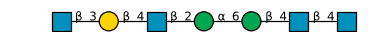

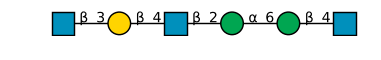

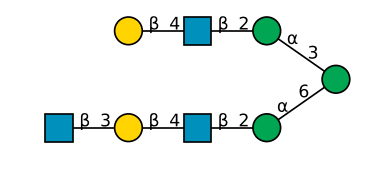

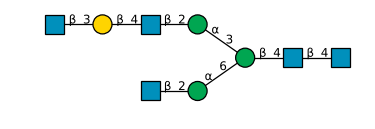

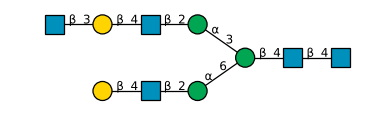

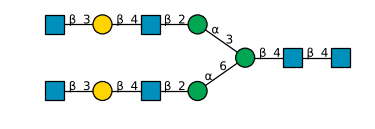

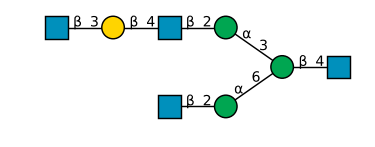

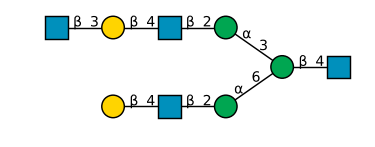

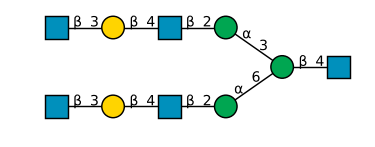

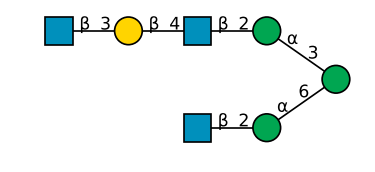

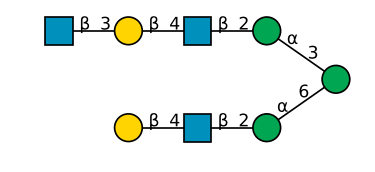

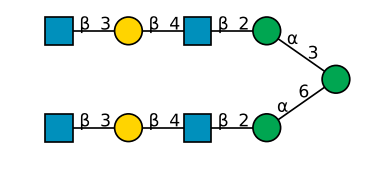

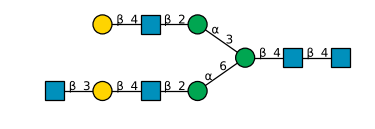

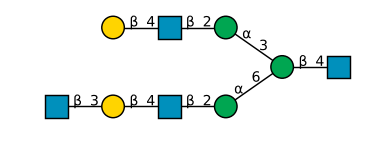

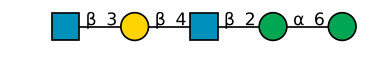

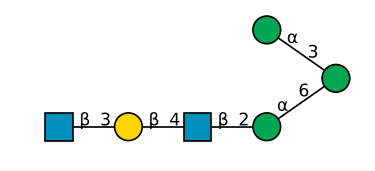

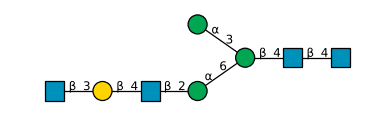

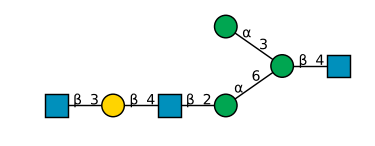

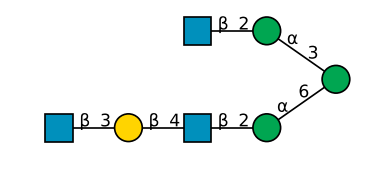

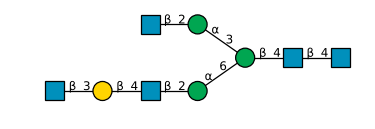

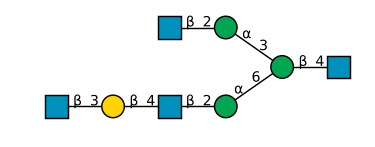

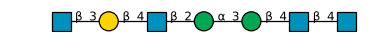

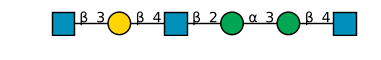

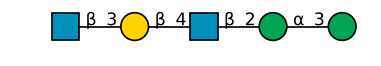

In [10]:
for motif in motifs:
    fig, ax = plt.subplots()
    draw_glycan_diagram(motif, ax)
    fig.show()